# IMDB-WIKI Convert .mat

In [1]:
import os
import os.path as osp
from os.path import join
from glob import glob
import random
import math
from datetime import datetime

import cv2 as cv
import pandas as pd
from scipy.io import loadmat
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
%reload_ext autoreload
%autoreload 2

## Load Metadata

In [2]:
fp_mat = '/data_store_hdd/datasets/people/imdb_wiki/downloads/imdb.mat'
dir_out = '/data_store_hdd/datasets/people/imdb_wiki/metadata/'

In [3]:
mat_data = loadmat(fp_mat)

In [4]:
# row 3
def load_parse_imdb_mat(mat):
  metadata = mat['imdb'][0][0]
  results = []
  num_records = len(metadata[0][0])
  print(f'loaded: {num_records} records')
  for i in tqdm(range(num_records), total=num_records):
    dob_matlab = metadata[0][0][i]
    dob = datetime.fromordinal(dob_matlab)
    dob_str = f'{dob.year}-{dob.month}-{dob.day}'
    year_photo = metadata[1][0][i]
    fp = metadata[2][0][i][0]
    gender_val = metadata[3][0][i]
    if gender_val == 0:
      gender = 'f'
    elif gender_val == 1:
      gender = 'm'
    else:
      gender = None
    name = metadata[4][0][i][0]
    roi = metadata[5][0][i][0]
    face_conf = metadata[6][0][i]
    face_conf_second = metadata[7][0][i]
    celeb_id = metadata[9][0][i]
    result = {
      'dob': dob_str,
      'year_photo': year_photo,
      'filepath': fp,
      'gender': gender,
      'name': name,
      'x1': roi[0],
      'y1': roi[1],
      'x2': roi[2],
      'y2': roi[3],
      'celeb_id': celeb_id
    }
    results.append(result)
  return results

In [5]:
results_meta = load_parse_imdb_mat(mat_data)

loaded: 460723 records


In [6]:
df_meta = pd.DataFrame.from_dict(results_meta)

In [7]:
df_meta.head()

celeb_id        dob                                      filepath gender  \
0      6488  1900-5-11   01/nm0000001_rm124825600_1899-5-10_1968.jpg      m   
1      6488  1900-5-11  01/nm0000001_rm3343756032_1899-5-10_1970.jpg      m   
2      6488  1900-5-11   01/nm0000001_rm577153792_1899-5-10_1968.jpg      m   
3      6488  1900-5-11   01/nm0000001_rm946909184_1899-5-10_1968.jpg      m   
4      6488  1900-5-11   01/nm0000001_rm980463616_1899-5-10_1968.jpg      m   

           name           x1           x2          y1          y2  year_photo  
0  Fred Astaire  1072.926000  1214.784000  161.838000  303.696000        1968  
1  Fred Astaire   477.184000   622.592000  100.352000  245.760000        1970  
2  Fred Astaire   114.969643   451.686572  114.969643  451.686572        1968  
3  Fred Astaire   622.885506   844.339008  424.217504  645.671006        1968  
4  Fred Astaire  1013.859002  1201.586128  233.882042  421.609168        1968

## Create DataFrame for metadata

In [8]:
df_results = pd.DataFrame.from_dict(results_meta)

In [9]:
df_results.head()

celeb_id        dob                                      filepath gender  \
0      6488  1900-5-11   01/nm0000001_rm124825600_1899-5-10_1968.jpg      m   
1      6488  1900-5-11  01/nm0000001_rm3343756032_1899-5-10_1970.jpg      m   
2      6488  1900-5-11   01/nm0000001_rm577153792_1899-5-10_1968.jpg      m   
3      6488  1900-5-11   01/nm0000001_rm946909184_1899-5-10_1968.jpg      m   
4      6488  1900-5-11   01/nm0000001_rm980463616_1899-5-10_1968.jpg      m   

           name           x1           x2          y1          y2  year_photo  
0  Fred Astaire  1072.926000  1214.784000  161.838000  303.696000        1968  
1  Fred Astaire   477.184000   622.592000  100.352000  245.760000        1970  
2  Fred Astaire   114.969643   451.686572  114.969643  451.686572        1968  
3  Fred Astaire   622.885506   844.339008  424.217504  645.671006        1968  
4  Fred Astaire  1013.859002  1201.586128  233.882042  421.609168        1968

In [10]:
df_results.index.name = 'index'
df_results.to_csv(join(dir_out,'imdb_wiki.csv'))

## Count Images per Person

In [11]:
df_name_groups = df_results.groupby('name')
images_per_person = []
for name, df_name in df_name_groups:
  images_per_person.append({'name': name, 'num_images': len(df_name)})
df_images_per_person = pd.DataFrame.from_dict(images_per_person)
df_images_per_person.index.name = 'index'
df_images_per_person.to_csv(join(dir_out, 'imdb_images_per_person.csv'), index=False)

# Find Face Size

In [12]:
sizes = [(x['x2'] - x['x1']) for x in results_meta]

In [13]:
buckets = list(range(0,500,50))

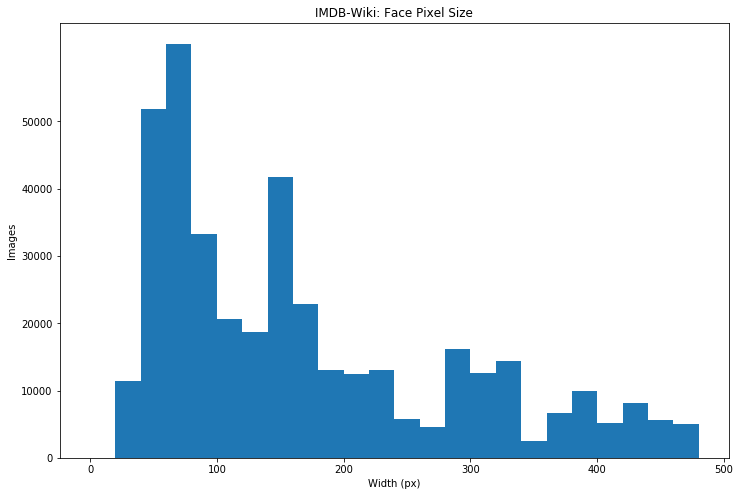

In [14]:
from matplotlib import pyplot as plt 
import numpy as np  
bins = list(range(0,500,20))
plt.figure(figsize=(12,8))
plt.hist(sizes, bins=bins)
plt.title("Face Image Sizes") 
plt.ylabel("Images")
plt.xlabel("Width (px)")
plt.yticks(range(0, 60000, 10000))
plt.title('IMDB-Wiki: Face Pixel Size')

plt.show()

```
dob: date of birth (Matlab serial date number)
photo_taken: year when the photo was taken
full_path: path to file
gender: 0 for female and 1 for male, NaN if unknown
name: name of the celebrity
face_location: location of the face. To crop the face in Matlab run

img(face_location(2):face_location(4),face_location(1):face_location(3),:))

face_score: detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image
second_face_score: detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.
celeb_names (IMDB only): list of all celebrity names
celeb_id (IMDB only): index of celebrity name
```